In [4]:
import json
import glob
import pprint as pp
import numpy as np
import pandas as pd

In [5]:
combined = []
for json_file in glob.glob("jsn/*.json"):
    with open(json_file, "rb") as infile:
        combined.append(json.load(infile))

#pp.pprint(combined)

In [6]:
description, title, url, keywords = [], [], [], []

In [7]:
for i in range(11):
    for j in range(100):
        description.append(combined[i]['items'][j]['meta_description'])
        title.append(combined[i]['items'][j]['meta_title'])
        url.append(combined[i]['items'][j]['canonical_url'])
        try:
            keywords.append(combined[i]['items'][j]['meta_keywords'])
        except KeyError:
            keywords.append(np.nan)

In [8]:
d = {'description': description, 'title': title, 'url': url, 'keywords': keywords}
df = pd.DataFrame(d)

In [9]:
df

,description,title,url,keywords
0,Бизнесмен Дмитрий Мазуров арестован до 12 сент...,Основателя крупнейшего в России независимого Н...,https://www.rbc.ru/business/15/07/2019/5d2b997...,"Сбербанк, Мазуров, Антипинский, Знакомый, Собе..."
1,Банк обратился в органы по фактам незаконных д...,Сбербанк сообщил правоохранителям о незаконных...,https://www.rbc.ru/rbcfreenews/5d2c605d9a79478...,"Предприятие, Антипинский, Мазуров, Мошенничест..."
2,Россияне продолжат тратить существенную часть ...,Сбербанк спрогнозировал неизменность высоких р...,https://www.rbc.ru/economics/13/07/2019/5d2857...,"Население, Сбережение, Квартал, Расход, Сберба..."
3,Сбербанк улучшил прогноз по курсу рубля на 201...,Сбербанк улучшил прогноз по курсу рубля,https://www.rbc.ru/finances/12/07/2019/5d27477...,"Экономист, Лисоволик, Аналитика, Нерезидент, У..."
4,"Марина Жигалова-Озкан, 13 лет возглавляющая Di...",Глава Disney в России станет старшим вице-през...,https://www.rbc.ru/business/10/07/2019/5d25f7f...,"Сбербанк, Компания, Жигалов, Президент, Говори..."
...,...,...,...,...
1095,Отток валютных средств населения из госбанков ...,Вопреки ожиданиям: почему в сентябре замедлилс...,https://www.rbc.ru/finances/25/10/2018/5bd1e74...,"Валютный, Сентябрь, Население, Средство, Госба..."
1096,Мы рассчитываем к концу 2020 года выйти в топ-...,Маркетплейс «Яндекса» и Сбербанка запланировал...,https://www.rbc.ru/rbcfreenews/5bd042f49a79474...,"Маркетплейс, Гришак, Развитие, Создание, Прода..."
1097,Региональный перевозчик будет создаваться путе...,Сбербанк не станет акционером создаваемой с ВТ...,https://www.rbc.ru/business/24/10/2018/5bd0420...,"Сбербанк, Авиакомпания, Региональный, Воздушны..."
1098,Крупнейший игрок рынка ипотеки — Сбербанк — по...,Конец дешевой ипотеки: что будет с кредитами н...,https://www.rbc.ru/finances/22/10/2018/5bcd851...,"Ипотечный, Сбербанк, Повышение, Сентябрь, Кред..."


In [7]:
df.isna().sum()

description    0
title          0
url            0
keywords       1
dtype: int64

In [8]:
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
pip install pyLDAvis==3.2.2

In [9]:
import re
from pprint import pprint


import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel


import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [10]:
from nltk.corpus import stopwords
stop_words = stopwords.words('russian')

In [11]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield (gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [12]:
res = list(sent_to_words([df.description[0]]))
res

[['бизнесмен',
  'дмитрии',
  'мазуров',
  'арестован',
  'до',
  'сентября',
  'по',
  'уголовному',
  'делу',
  'возбужденному',
  'по',
  'заявлению',
  'антипинского',
  'нпз',
  'его',
  'кредитора',
  'сбербанка',
  'рбк',
  'разбирался',
  'как',
  'мазуров',
  'из',
  'одного',
  'из',
  'крупнеиших',
  'заемщиков',
  'превратился',
  'обвиняемого']]

In [13]:
data_words = list(sent_to_words(df.description))
#df['pr_desc'] = data_words.copy()
#df.head()

In [14]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
!pip install spacy==3.0.0

In [ ]:
!python3 -m spacy download ru_core_news_lg

In [16]:
data_words_nostops = remove_stopwords(data_words)

nlp = spacy.load('ru_core_news_lg', disable=['parser', 'ner'])

# Do lemmatization
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['бизнесмен', 'дмитрии', 'мазуров', 'арестовать', 'сентябрь', 'уголовный', 'дело', 'возбужденному', 'заявление', 'антипинского', 'нпз', 'кредитор', 'сбербанк', 'рбк', 'разбираться', 'мазуров', 'крупнеиших', 'заёмщик', 'превратиться', 'обвиняемого']]


In [17]:
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1)]]


In [18]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('антипинского', 1),
  ('арестовать', 1),
  ('бизнесмен', 1),
  ('возбужденному', 1),
  ('дело', 1),
  ('дмитрии', 1),
  ('заявление', 1),
  ('заёмщик', 1),
  ('кредитор', 1),
  ('крупнеиших', 1),
  ('мазуров', 2),
  ('нпз', 1),
  ('обвиняемого', 1),
  ('превратиться', 1),
  ('разбираться', 1),
  ('рбк', 1),
  ('сбербанк', 1),
  ('сентябрь', 1),
  ('уголовный', 1)]]

In [19]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [20]:
#example for 20 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.045*"втб" + 0.033*"год" + 0.030*"банк" + 0.027*"правительство" + '
  '0.026*"конец" + 0.019*"средний" + 0.018*"сентябрь" + 0.015*"март" + '
  '0.015*"бренд" + 0.013*"прошлый"'),
 (1,
  '0.031*"бизнес" + 0.029*"назвать" + 0.028*"владелец" + 0.022*"число" + '
  '0.020*"компания" + 0.018*"московскои" + 0.017*"увеличить" + 0.015*"связать" '
  '+ 0.014*"являться" + 0.014*"бирже"'),
 (2,
  '0.045*"клиент" + 0.040*"млн" + 0.033*"карта" + 0.033*"сообщать" + '
  '0.023*"произойти" + 0.023*"месяц" + 0.021*"украина" + 0.020*"сеть" + '
  '0.019*"офис" + 0.018*"сбербанк"'),
 (3,
  '0.076*"ставка" + 0.039*"эксперт" + 0.032*"планировать" + 0.028*"страна" + '
  '0.025*"снизить" + 0.017*"ипотека" + 0.017*"отток" + 0.017*"млрд" + '
  '0.016*"речь" + 0.015*"впервые"'),
 (4,
  '0.028*"счёт" + 0.023*"банк" + 0.023*"возможность" + 0.021*"риск" + '
  '0.019*"другие" + 0.017*"ноябрь" + 0.016*"которои" + 0.016*"отказаться" + '
  '0.015*"закон" + 0.014*"цифровой"'),
 (5,
  '0.092*"греф" + 0.091*"глава

In [21]:
#visualization
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
19     0.301192  0.096695       1        1  13.037233
18     0.123672 -0.240153       2        1   8.637443
8      0.047157 -0.033862       3        1   6.295002
5      0.065794  0.042794       4        1   6.221336
14     0.123934  0.084453       5        1   5.344699
9      0.067054  0.016773       6        1   5.222239
12    -0.017015 -0.140408       7        1   4.704893
7      0.031587 -0.204610       8        1   4.675935
4     -0.005422  0.104778       9        1   4.356690
13     0.007518  0.098548      10        1   4.272532
3     -0.113091 -0.047860      11        1   4.171890
10    -0.047296  0.045128      12        1   3.880318
0     -0.003525  0.003417      13        1   3.855767
6     -0.040149 -0.011101      14        1   3.805552
2      0.031246  0.037931      15        1   3.729234
11    -0.052987  0.075194      16        1   3.620172
17    -0.119637  0.027449      17        1   3.604233
15    -0.163041  0.024053      18        1   3.580511
16    -0.094209  0.019092      19        1   3.541909
1     -0.142783  0.001687      20        1   3.442413, topic_info=          Term        Freq       Total Category  logprob  loglift
62         год  200.000000  200.000000  Default  30.0000  30.0000
153       греф  115.000000  115.000000  Default  29.0000  29.0000
152      глава  114.000000  114.000000  Default  28.0000  28.0000
15         рбк  160.000000  160.000000  Default  27.0000  27.0000
20        банк  397.000000  397.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
477     бизнес   21.705584   40.421775  Topic20  -3.4615   2.7472
739    госбанк    8.656430   15.303309  Topic20  -4.3808   2.7992
1352    бумага    7.218097   13.731750  Topic20  -4.5625   2.7259
132   компания   13.898417  141.976413  Topic20  -3.9073   1.0451
411      стать    7.673722   79.643539  Topic20  -4.5013   1.0292

[797 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
924      11  0.951081        август
645       4  0.965082  авиакомпания
4058     13  0.890324         автор
185       2  0.970524     агентство
380       3  0.523511         актив
...     ...       ...           ...
3531      3  0.815714   электронный
1285      9  0.963511          этои
487      20  0.969931      являться
1363      8  0.953137        январь
103       3  0.984414        яндекс

[865 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[20, 19, 9, 6, 15, 10, 13, 8, 5, 14, 4, 11, 1, 7, 3, 12, 18, 16, 17, 2])

In [22]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [23]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=3)

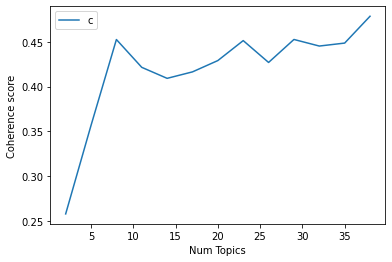

In [24]:
limit=40; start=2; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [25]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.258
Num Topics = 5  has Coherence Value of 0.3567
Num Topics = 8  has Coherence Value of 0.4525
Num Topics = 11  has Coherence Value of 0.4214
Num Topics = 14  has Coherence Value of 0.4092
Num Topics = 17  has Coherence Value of 0.4164
Num Topics = 20  has Coherence Value of 0.429
Num Topics = 23  has Coherence Value of 0.4512
Num Topics = 26  has Coherence Value of 0.4269
Num Topics = 29  has Coherence Value of 0.4525
Num Topics = 32  has Coherence Value of 0.4452
Num Topics = 35  has Coherence Value of 0.4485
Num Topics = 38  has Coherence Value of 0.4784


In [64]:
#choose optimal model by coherence value above
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
#pprint(optimal_model.print_topics(num_words=10))

Find best topic for every text in data


In [65]:
data = df.description.values.tolist()
#pprint(data[:1])

def format_topics_sentences(ldamodel, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        #print(row)
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return (sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,5.0,0.4438,"цб, акция, сбербанк, яндекс, доля, сделка, дол...",Бизнесмен Дмитрий Мазуров арестован до 12 сент...
1,1,5.0,0.5503,"цб, акция, сбербанк, яндекс, доля, сделка, дол...",Банк обратился в органы по фактам незаконных д...
2,2,6.0,0.3648,"отметить, помощь, регион, деньга, кузнецов, ра...",Россияне продолжат тратить существенную часть ...
3,3,5.0,0.6708,"цб, акция, сбербанк, яндекс, доля, сделка, дол...",Сбербанк улучшил прогноз по курсу рубля на 201...
4,4,6.0,0.6230,"отметить, помощь, регион, деньга, кузнецов, ра...","Марина Жигалова-Озкан, 13 лет возглавляющая Di..."
5,5,3.0,0.5451,"ставка, сбербанк, слово, вклад, акция, яндекс,...","То, что у Сбербанка и «Яндекса» есть разноглас..."
6,6,1.0,0.5568,"сбербанк, банк, рбк, клиент, сообщить, компани...","Точная причина недовольства сторон тем, как ид..."
7,7,3.0,0.5473,"ставка, сбербанк, слово, вклад, акция, яндекс,...",Сбербанк снизил максимальные процентные ставки...
8,8,1.0,0.8128,"сбербанк, банк, рбк, клиент, сообщить, компани...",Сбербанк пообещал найти решение по урегулирова...
9,9,1.0,0.4470,"сбербанк, банк, рбк, клиент, сообщить, компани...",Сбербанк получил все необходимые разрешения дл...


# Part 2

Text classification

In [28]:
pip install tokenizers

     |████████████████████████████████| 3.3MB 5.5MB/s 


In [66]:
#Tokenization
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace

tokenizer = Tokenizer(BPE())
trainer = BpeTrainer(special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]"])
tokenizer.pre_tokenizer = Whitespace()
tokenizer.train_from_iterator(df_dominant_topic.Text.values, trainer=trainer)

In [100]:
X = []
MAX_LENGTH = 32
for t in df_dominant_topic.Text:
    if type(t) == str:
        enc = tokenizer.encode(t).ids
        if len(enc) >= MAX_LENGTH:
            X.append([1] + enc[:MAX_LENGTH])
        else:
            X.append([1] + enc + [3] * (MAX_LENGTH - len(enc)))
X = np.array(X)

In [101]:
Y = pd.get_dummies(df_dominant_topic["Dominant_Topic"])
labels = Y.columns
Y = Y.values

In [102]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [ ]:
import tensorflow as tf
import os
#Get a handle to the attached TPU. On GCP it will be the CloudTPU itself
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
#Connect to the TPU handle and initialise it
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

strategy = tf.distribute.experimental.TPUStrategy(resolver)

In [113]:
import keras.backend as bk

bk.clear_session()

In [114]:
from keras.models import Sequential
from keras.layers import Embedding, Dense, Dropout, SpatialDropout1D, LSTM, Bidirectional, BatchNormalization, Conv1D, MaxPooling1D, Flatten


with strategy.scope():
    model = Sequential()
    model.add(Embedding(1000, 50, input_length=X.shape[1]))
    #model.add(SpatialDropout1D(0.2))
    model.add(Conv1D(filters=8, kernel_size=3, padding="same", activation='relu'))
    model.add(Conv1D(filters=16, kernel_size=3, padding="same", activation='relu'))
    model.add(MaxPooling1D(pool_size=3))
    #model.add(Dropout(.25))
    model.add(Conv1D(filters=16, kernel_size=3, padding="same", activation='relu'))
    model.add(Conv1D(filters=32, kernel_size=3, padding="same", activation='relu'))
    model.add(MaxPooling1D(pool_size=3))
    #model.add(Dropout(.25))
    model.add(Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(128, activation="relu"))
    model.add(Dense(Y.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
batch_size = 8

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1)

Epoch 1/10
99/99 [==============================] - 19s 56ms/step - loss: 2.0704 - accuracy: 0.3884 - val_loss: 2.0385 - val_accuracy: 0.4318
Epoch 2/10
99/99 [==============================] - 2s 22ms/step - loss: 2.0348 - accuracy: 0.3845 - val_loss: 2.0010 - val_accuracy: 0.4318
Epoch 3/10
99/99 [==============================] - 2s 22ms/step - loss: 2.0036 - accuracy: 0.3824 - val_loss: 1.9663 - val_accuracy: 0.4318
Epoch 4/10
99/99 [==============================] - 2s 22ms/step - loss: 1.9747 - accuracy: 0.3923 - val_loss: 1.9367 - val_accuracy: 0.4318
Epoch 5/10
99/99 [==============================] - 2s 23ms/step - loss: 1.9472 - accuracy: 0.3809 - val_loss: 1.9104 - val_accuracy: 0.4318
Epoch 6/10
99/99 [==============================] - 3s 28ms/step - loss: 1.9292 - accuracy: 0.3851 - val_loss: 1.8875 - val_accuracy: 0.4318
Epoch 7/10
99/99 [==============================] - 2s 22ms/step - loss: 1.9026 - accuracy: 0.3996 - val_loss: 1.8671 - val_accuracy: 0.4318
Epoch 8/10
9

In [115]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

7/7 [==============================] - 5s 23ms/step - loss: 1.8734 - accuracy: 0.3864
Test set
  Loss: 1.873
  Accuracy: 0.386


Another approach using RandomForest

In [ ]:
Y_ = df_dominant_topic["Dominant_Topic"].values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_, test_size = 0.2)

In [88]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

lr_m = RandomForestClassifier()
lr_m.fit(X_train, Y_train)
preds = lr_m.predict(X_test)
print(accuracy_score(Y_test, preds))

0.38181818181818183


# NER Task

NER. Обязательно бызовые вещи с помощью готового метода - люди, фирмы, цифры. Также мб что-то кастомное

In [ ]:
pip install deeppavlov

In [ ]:
!python3 -m deeppavlov install ner_rus_bert

In [ ]:
from deeppavlov import configs, build_model

ner_model = build_model(configs.ner.ner_rus_bert, download=True)

In [ ]:
 p_ = ner_model([df.description.tolist()[0]])
sent = []
for i in range(len(p_[0][0])):
    if p_[1][0][i] != 'O':
        sent.append(p_[0][0][i] + '-' + p_[1][0][i])
print(sent)